# Credit Card Fraud Detection

## Data Preparation

The data is already fairly well prepared, as it was cleaned and ran through PCA (in order to ensure anonymity). 

It still needs to be split before training any models.
It is **very important** to ensure equal proportions of fraudulent transactions in each subset of data (train/validation/test)

In [2]:
# import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#sklearn will be imported partially when necessary

#read in the data and make a copy of it in case anything goes wrong
path = "C:/Users/ms101/OneDrive/datasets"
credit_data = pd.read_csv(path + "/creditcard.csv")

data = credit_data.copy()


In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We already checked for missing values during the exploration, one more thing to look for are **duplicates**. These could potentially lead to biased metrics.

In [4]:
data.duplicated().sum()

1081

There are 1081 duplicate entries which should be dropped.

In [5]:
print(data.shape)
data.drop_duplicates(inplace = True)
data.reset_index(inplace = True, drop = True)

(284807, 31)


In [6]:
data.shape

(283726, 31)

In [7]:
assert data.shape == (284807-1081,31)#check if duplicates are removed correctly

### Selecting the features

In the explorative analysis the following features were found to be most strongly related to the target.

["V17","V14","V12","V10","V16","V3","V7","V11"]

The features will therefore be reduced to those 8 features.

In [12]:
data_red = data[["V17","V14","V12","V10","V16","V3","V7","V11","Class"]].copy()
data_red.head()

,V17,V14,V12,V10,V16,V3,V7,V11,Class
0,0.207971,-0.311169,-0.617801,0.090794,-0.470401,2.536347,0.239599,-0.551600,0
1,-0.114805,-0.143772,1.065235,-0.166974,0.463917,0.166480,-0.078803,1.612727,0
2,1.109969,-0.165946,0.066084,0.207643,-2.890083,1.773209,0.791461,0.624501,0
3,-0.684093,-0.287924,0.178228,-0.054952,-1.059647,1.792993,0.237609,-0.226487,0
4,-0.237033,-1.119670,0.538196,0.753074,-0.451449,1.548718,0.592941,-0.822843,0


### Splitting the data

I will use a stratified shuffle split, which ensures, that the proportions of classes within all subsets are equal.

I will not split of a seperate validation set at this point because I aim to utilize cross-validation.

In [13]:
X = data_red.drop("Class", axis = 1)
y = data_red["Class"]

In [14]:
X.shape

(283726, 8)

In [15]:
y.shape

(283726,)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(test_size = 0.2, random_state = 13)
for train_index, test_index in strat_split.split(X,y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

In [17]:
X_train.shape, y_train.shape

((226980, 8), (226980,))

In [18]:
X_test.shape, y_test.shape

((56746, 8), (56746,))

Now we should check if the proportions of fraudulent cases are similar in both subset.

In [19]:
train_counts = y_train.value_counts()
train_ratio = train_counts[1]/train_counts[0]

In [20]:
test_counts = y_test.value_counts()
test_ratio = test_counts[1]/test_counts[0]

In [21]:
train_ratio.round(5) , test_ratio.round(5)

(0.00167, 0.00168)

They are very similar our data split was a success.

## Model Selection

### Baseline Model and "Classic" Classification Models

The first model which will act as a baseline for others will be a Logistic Regression with fairly standard parameters.

I also aim to try other "classic" classification models before going into more specialized models for outlier/anomaly detection such as Gaussian Mixture Models.

From all models the most promising ones will be select and tuned further.

I will consider combining multiple models into an ensemble by voting or stacking.

The metrics will be:
- precision
- recall (aiming for a high recall/sensitivity)

To determine good models I will used cross-validation which will again use a stratified approach to ensure similar target-value ratios.



In [22]:
# import the metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_auc_score


The normal `cross_val_score` from sklearn samples randomly when splitting the data into train and validation set. I want to avoid that for the mentioned reasons. Therefore the following function will be used instead. 

*Note: Parts of this code were adapted from Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurélien Géron)*

**I discovered that `cross_val_score` actually does use `StratifiedKFold` when given certain parameters. It will therefore be used here. I am keeping the function for documentation purposes.**

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [24]:
def strat_cross_val_score(classifier,X_train, y_train, cv = 5, scoring = "accuracy"):
    """
    Runs n-fold cross-validation with stratified sampling.

    Parameters
    ----------
    classifier : sklearn Classifier to evaluate
    X_train : Training set of features.
    y_train : Training set of the target values.
    cv : n-folds for the cross validation
    scoring: Method of scoring ("accuracy","precision_recall", "roc_auc")

    Returns
    -------
    The score of the chosen metric for each round of cross-validation.

    """
    
    skfolds = StratifiedKFold(n_splits = cv, shuffle = True ,random_state = 13)
    """for train_index, test_index in strat_split.split(X,y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]"""
    for train_index, test_index in skfolds.split(X_train, y_train):
        clone_clf = clone(classifier)
        X_train_folds, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_folds, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
                 
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        #for accuracy
        if scoring == "accuracy":
            n_correct = sum(y_pred == y_test_fold)
            print("Accuracy: ",n_correct / len(y_pred))
        #for precision and recall
        if scoring == "precision_recall":
            print("Precision: ", precision_score(y_test_fold, y_pred))
            print("Recall: ", recall_score(y_test_fold,y_pred))
        #for roc_auc
        if scoring == "roc_auc":
            print("ROC AUC Score: ", roc_auc_score(y_test_fold, y_pred))

In [25]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

log_clf = LogisticRegression(n_jobs = -1)
forest_clf = RandomForestClassifier(random_state = 13, n_jobs = -1)
NB_clf = GaussianNB()
MLP_clf = MLPClassifier()
svm_clf = SVC()

In [21]:
#Testing the above function
#strat_cross_val_score(forest_clf, X_train, y_train, scoring = "precision_recall")

Precision:  0.9295774647887324
Recall:  0.88
Precision:  0.9827586206896551
Recall:  0.76
Precision:  0.9661016949152542
Recall:  0.75
Precision:  0.8970588235294118
Recall:  0.8026315789473685
Precision:  0.9047619047619048
Recall:  0.75


In [27]:
from sklearn.model_selection import cross_val_score, cross_val_predict


In [28]:
classifiers = [log_clf, forest_clf, NB_clf, MLP_clf, svm_clf]
clf_names = ["Logistic Regression", "Random Forest", "Naive Bayes", "MLP", "SVM"]
for classifier,name in zip(classifiers,clf_names):
    print(name)
    scores = cross_val_score(classifier,X_train_scaled,y_train, scoring = "recall")
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

Logistic Regression
Scores:  [0.57333333 0.74666667 0.59210526 0.52631579 0.47368421]
Mean:  0.582421052631579
Std:  0.09178724714290791
Random Forest
Scores:  [0.72       0.84       0.80263158 0.80263158 0.77631579]
Mean:  0.7883157894736843
Std:  0.03972955666918768
Naive Bayes
Scores:  [0.78666667 0.86666667 0.86842105 0.86842105 0.86842105]
Mean:  0.8517192982456139
Std:  0.032533412045982035
MLP
Scores:  [0.70666667 0.82666667 0.78947368 0.81578947 0.72368421]
Mean:  0.7724561403508773
Std:  0.048606813774789086
SVM
Scores:  [0.64       0.76       0.71052632 0.75       0.67105263]
Mean:  0.7063157894736842
Std:  0.045715002962319444


Judging from this the Gaussian Naive Bayes, MLP and Random Forest did best. It makes sense to also check the precision scores of all models to make sure, that the trade-off is not too large for our best performing models.

In [29]:
for classifier,name in zip(classifiers,clf_names):
    print(name)
    scores = cross_val_score(classifier,X_train_scaled,y_train, scoring = "precision")
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

Logistic Regression
Scores:  [0.93478261 0.88888889 0.78947368 0.93023256 0.85714286]
Mean:  0.8801041194154917
Std:  0.05351796910228498
Random Forest
Scores:  [0.94736842 0.92647059 0.91044776 0.92424242 0.93650794]
Mean:  0.9290074262464632
Std:  0.012385360249153286
Naive Bayes
Scores:  [0.12139918 0.12596899 0.13306452 0.13043478 0.12382739]
Mean:  0.1269389720121195
Std:  0.004267437214546553
MLP
Scores:  [0.91525424 0.83783784 0.84057971 0.91304348 0.89285714]
Mean:  0.8799144812777827
Std:  0.034151455102179325
SVM
Scores:  [0.96       0.93442623 0.93103448 0.98275862 0.94444444]
Mean:  0.9505327554801835
Std:  0.018998976059649404


The Random Forest also has high precision which is quite promising. I could tune it towards better recall, without risking extremely low precision.

The Naive Bayes Classifier has extremely low precision, which is not great. It seems that the high recall comes at a very high cost.

I will visualize the precision-recall curves for the Random Forest, Naive Bayes and the MLP (as it showed reasonable recall and high precision). After that I will evaluate models that are more suited to outlier detection before selecting a final one.

*The function for the visualiazation is taken from Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurélien Géron.*

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)                            

In [31]:
# get the predictions and store them for later use

y_pred_forest = cross_val_predict(forest_clf,X_train_scaled, y_train) #no scaling needed but used to introduce no bias when comparing
y_pred_NB = cross_val_predict(NB_clf,X_train_scaled, y_train)
y_pred_MLP = cross_val_predict(MLP_clf,X_train_scaled, y_train)

#### Add in - Start

#### At a later stage I realised that, the SVC had decent recall with very high precision. I thus decided to view it's precision recall curve as well.

In [105]:
y_pred_svc = cross_val_predict(svm_clf,X_train_scaled, y_train)

Precision:  0.9501779359430605
Recall:  0.7063492063492064
TN       FP
[[226588     14]
 [   111    267]]
FN       TP


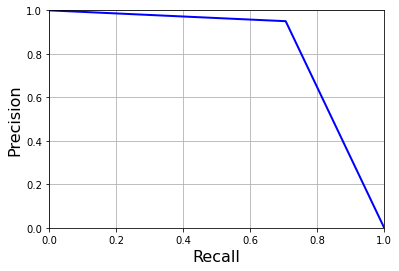

<Figure size 576x288 with 0 Axes>

In [106]:
print("Precision: ", precision_score(y_train,y_pred_svc))
print("Recall: ", recall_score(y_train,y_pred_svc))
print("TN       FP")
print(confusion_matrix(y_train,y_pred_svc)) 
print("FN       TP")
precisions, recalls, thresholds = precision_recall_curve(y_train,y_pred_svc)
plot_precision_vs_recall(precisions,recalls) #plot precision recall curve
plt.figure(figsize=(8,4))
plt.show()

It doesn't perform to bad but the Precision at high Recall levels would be lower than for the Random Forest

#### Add-in Stop

Random Forest
Precision:  0.9283489096573209
Recall:  0.7883597883597884
TN       FP
[[226579     23]
 [    80    298]]
FN       TP


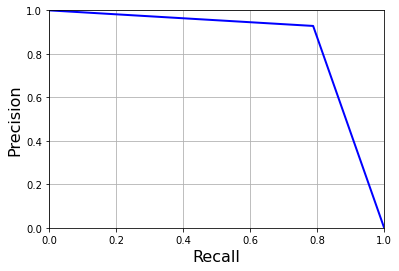

<Figure size 576x288 with 0 Axes>

NB
Precision:  0.12692156089869924
Recall:  0.8518518518518519
TN       FP
[[224387   2215]
 [    56    322]]
FN       TP


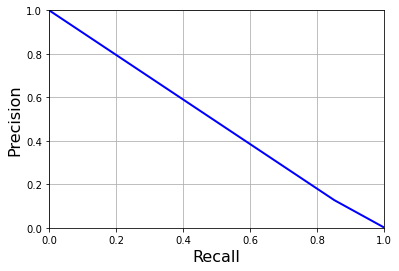

<Figure size 576x288 with 0 Axes>

MLP
Precision:  0.8605341246290801
Recall:  0.7671957671957672
TN       FP
[[226555     47]
 [    88    290]]
FN       TP


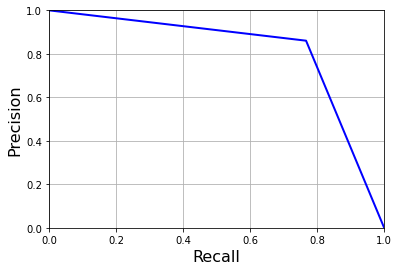

<Figure size 576x288 with 0 Axes>

In [32]:
for y_pred,name in zip([y_pred_forest,y_pred_NB,y_pred_MLP],["Random Forest", "NB", "MLP"]):
    print(name)
    print("Precision: ", precision_score(y_train,y_pred))
    print("Recall: ", recall_score(y_train,y_pred))
    print("TN       FP")
    print(confusion_matrix(y_train,y_pred)) 
    print("FN       TP")
    precisions, recalls, thresholds = precision_recall_curve(y_train,y_pred)
    plot_precision_vs_recall(precisions,recalls) #plot precision recall curve
    plt.figure(figsize=(8,4))
    plt.show()

The Random Forest model beformed best. Yet it also shows a steep decline in Precision after a Recall of about 0.8.

It will be used for further tuning and compared to models which are more specialized for anomaly detection.

### Anomaly Detection Models

Seeing how the performance of even the best classification model so far (with default parameters) was not very good (78/378, 20% False Negatives), I will explore some models that may be suited better to the task:

- a Bayesian Gaussian Mixture Model
- an Isolation Forest
- Local Outlier Factor Model

Again I will use default models to shortlist the most promising ones for further tuning.

In [33]:
# Isolation Forest
from sklearn.ensemble import IsolationForest

iso_clf = IsolationForest(random_state = 13)

In [34]:
y_pred_iso = iso_clf.fit_predict(X_train_scaled)


It may make sense to use predict_proba and a threshold for outlier detection models, IsolationForest however, due to it's root in decision trees doesn't have predict_proba.

In [35]:
# IsolationForest uses -1 for outliers (Class = 1 here) and 1 for inliers (Class = 0 here)
y_pred_iso[y_pred_iso == 1] = 0
y_pred_iso[y_pred_iso == -1] = 1

In [42]:
from sklearn.mixture import BayesianGaussianMixture

bgmm_clf = BayesianGaussianMixture(n_components = 9,n_init = 5) #n_init 1 as default could lead to convergence on a suboptimal solution
bgmm_clf.fit(X_train_scaled)
#y_pred_bgmm = bgmm_clf.fit_predict(X_train_scaled)
y_proba_bgmm = bgmm_clf.predict_proba(X_train_scaled)

In [84]:
#finding the anomalies 
densities = bgmm_clf.score_samples(X_train_scaled)
density_threshold = np.percentile(densities,1) # anomalies below 1% density

densities[densities >= density_threshold] = 0
densities[densities < density_threshold] = 1
densities

array([0., 0., 0., ..., 0., 0., 0.])

In [85]:
unique, counts = np.unique(densities, return_counts=True)
dict(zip(unique, counts))

{0.0: 224710, 1.0: 2270}

In [86]:
y_pred_bgmm = densities

In [98]:
from sklearn.neighbors import LocalOutlierFactor

LOF_clf = LocalOutlierFactor(n_jobs = -1)
y_preds_LOF = LOF_clf.fit_predict(X_train_scaled)

In [99]:
y_preds_LOF

array([ 1, -1,  1, ...,  1,  1,  1])

In [100]:
y_preds_LOF[y_preds_LOF == 1] = 0
y_preds_LOF[y_preds_LOF == -1] = 1

Isolation Forest
Precision:  0.019514707565525924
Recall:  0.9021164021164021
TN       FP
[[209469  17133]
 [    37    341]]
FN       TP


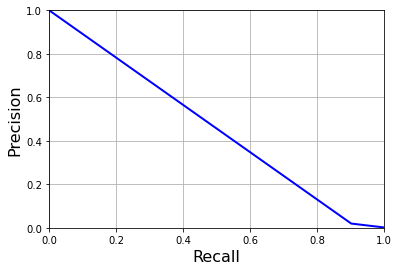

<Figure size 576x288 with 0 Axes>

BGMM
Precision:  0.13480176211453745
Recall:  0.8095238095238095
TN       FP
[[224638   1964]
 [    72    306]]
FN       TP


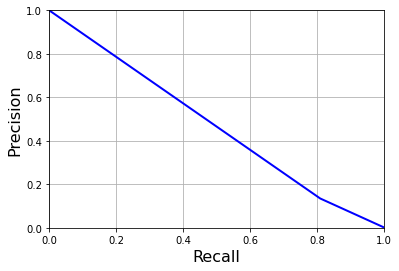

<Figure size 576x288 with 0 Axes>

LOF
Precision:  0.0019874393830988154
Recall:  0.06613756613756613
TN       FP
[[214048  12554]
 [   353     25]]
FN       TP


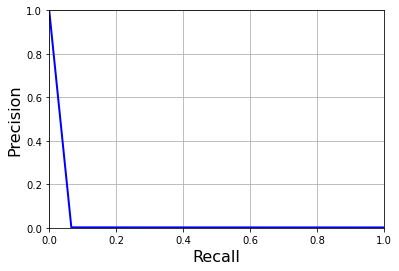

<Figure size 576x288 with 0 Axes>

In [102]:
for y_pred,name in zip([y_pred_iso,y_pred_bgmm,y_preds_LOF],["Isolation Forest", "BGMM", "LOF"]):
    print(name)
    print("Precision: ", precision_score(y_train,y_pred))
    print("Recall: ", recall_score(y_train,y_pred))
    print("TN       FP")
    print(confusion_matrix(y_train,y_pred)) 
    print("FN       TP")
    precisions, recalls, thresholds = precision_recall_curve(y_train,y_pred)
    plot_precision_vs_recall(precisions,recalls) #plot precision recall curve
    plt.figure(figsize=(8,4))
    plt.show()

- The Isolation Forest was better than the Random Forest in Finding TP, it has many more FP instances though.
- The Bayesian Gaussian Mixture Model has a FN rate similar to the Random Forest. However its Precision is much worth. A Random Forest fine-tuned towards Recall will probably be the better choice.
- The LOF performed quite poorly. It may need to be trained on a "clean" dataset without outliers, to detect them.

After all the Random Forest looks most promising. In the next step I will try to fine-tune it towards more recall. Which will probably come at the expense of some precision.

As ensemble methods may perform better than a single model I will also fine tune the MLP towards better recall and possibly use it for an ensemble.

I aim to get the lowest number of False Negatives, which are the worst thing in our problem. As those would be fraud-instances that go unnoticed. While keeping the FP rate as low as possible.

The last statement is quite flexible. I therefore aim to stay below 3000 FP instances.